<a href="https://colab.research.google.com/github/guen-a-park/Motion-Keypoint-Detection/blob/main/%5B%EC%BD%94%EB%93%9C%5D_%EB%8D%B0%EC%9D%B4%EC%BD%98_%EB%B2%A0%EC%9D%B4%EC%8A%A4%EB%9D%BC%EC%9D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Library Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from PIL import Image
import os
import cv2

from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, concatenate, Input, Flatten, Dense
from tensorflow.keras import Model

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#폴더 경로를 설정해줍니다.
os.chdir('/content/drive/MyDrive/1. open') 

In [ ]:
#제공된 데이터들의 리스트를 확인합니다.
os.listdir()

['sample_submission.csv',
 'train_df.csv',
 'test_imgs.zip',
 'train_imgs.zip',
 'test_imgs',
 'train_imgs']

# 데이터 불러오고 살펴보기 

In [ ]:
train = pd.read_csv('train_df.csv')
submission = pd.read_csv('sample_submission.csv')

train.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.48423,1020.117796,338.890539,1048.000000,343.000000,992.0,394.0,1054.0,400.0,956.0,368.0,1134.0,371.0,1003.497242,327.640085,1078.0,341.0,999.0,570.0,1046.0,573.0,995.0,695.0,1054.0,698.0,983.000000,820.000000,1042.0,829.0,1019.107277,373.766222,1013.137360,316.311695,1067.00000,335.0,1019.484230,455.000000,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.59369,1041.422997,331.694815,1065.593682,333.968459,1010.0,398.0,1077.0,386.0,974.0,398.0,1144.0,337.0,1004.000000,346.000000,1094.0,326.0,1020.0,557.0,1069.0,567.0,1013.0,583.0,1072.0,697.0,1003.843781,678.797029,1042.0,829.0,1047.279440,362.031898,1017.383112,332.890539,1081.18738,323.0,1046.953248,454.062706,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445


In [ ]:
train.shape

(4195, 49)

In [ ]:
#submission 파일 불러오기
submission.head(2)

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,649-2-4-32-Z148_A-0000003.jpg,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
#glob를 활용해 이미지의 경로들을 불러옵니다.
import glob
train_paths = sorted(glob.glob('./train_imgs/*.jpg'))
test_paths = sorted(glob.glob('./test_imgs/*.jpg'))
print(len(train_paths), len(test_paths))

4195 1600


# 시각화

주어진 이미지와 keypoint지점을 비교해보며 데이터에 대한 이해도를 높여봐요!

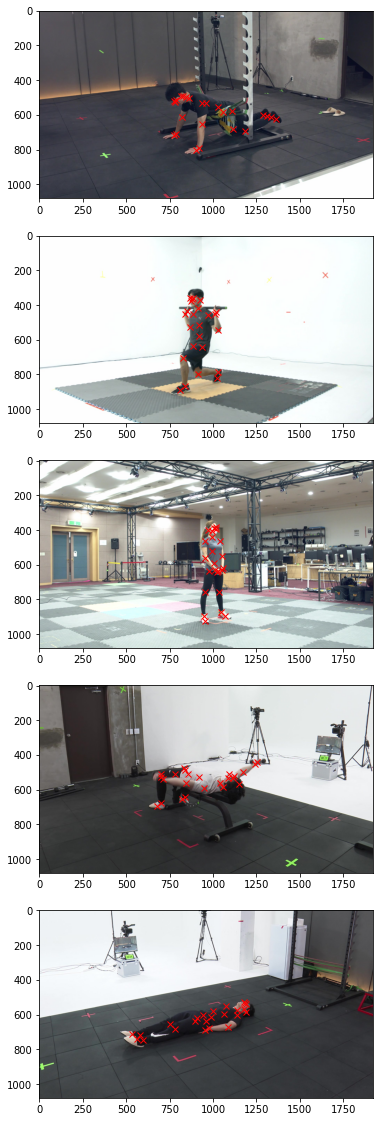

In [ ]:
plt.figure(figsize=(40,20))
count=1

for i in np.random.randint(0,len(train_paths),5):
    
    plt.subplot(5,1, count)
    
    img_sample_path = train_paths[i]
    img = Image.open(img_sample_path)
    img_np = np.array(img)

    keypoint = train.iloc[:,1:49] #위치키포인트 하나씩 확인
    keypoint_sample = keypoint.iloc[i, :]
    
    for j in range(0,len(keypoint.columns),2):
        plt.plot(keypoint_sample[j], keypoint_sample[j+1],'rx')
        plt.imshow(img_np)
    
    count += 1


# 모델링

In [ ]:
train['path'] = train_paths

NameError: ignored

대용량 이미지를 불러올 때 Generator 를 활용해서 불러옵니다.

In [ ]:
def trainGenerator():
    for i in range(len(train)):
        img = tf.io.read_file(train['path'][i]) # path(경로)를 통해 이미지 읽기
        img = tf.image.decode_jpeg(img, channels=3) # 경로를 통해 불러온 이미지를 decode
        img = tf.image.resize(img, [180,320]) # 이미지 resize 
        target = train.iloc[:,1:49].iloc[i,:] # keypoint 뽑아주기
        
        yield (img, target)

#generator를 활용해 데이터셋 만들기
from_generator(generator, output_types, output_shapes=None, args=None),https://jins-sw.tistory.com/14        
train_dataset = tf.data.Dataset.from_generator(trainGenerator, (tf.float32, tf.float32), (tf.TensorShape([180,320,3]),tf.TensorShape([48])))
train_dataset = train_dataset.batch(32).prefetch(1)

In [ ]:
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D,MaxPool2D, ZeroPadding2D

In [ ]:
#간단한 CNN 모델을 적용합니다.

model = Sequential()

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False, input_shape=(180,320,3)))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(32, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(64, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())

model.add(Convolution2D(96, (3,3), padding='same', use_bias=False))
model.add(LeakyReLU(alpha = 0.1))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(48))

NameError: ignored

In [ ]:
model.compile(optimizer='adam', 
              loss='mean_squared_error',
              metrics=['mae'])

In [ ]:
model.fit(train_dataset,epochs = 50, verbose=1)

Epoch 1/50
132/132 [==============================] - 1149s 8s/step - loss: 80069.7821 - mae: 186.8401
Epoch 2/50
132/132 [==============================] - 82s 617ms/step - loss: 17295.8773 - mae: 101.2369
Epoch 3/50
132/132 [==============================] - 81s 617ms/step - loss: 15645.6538 - mae: 94.8486
Epoch 4/50
132/132 [==============================] - 82s 617ms/step - loss: 14483.9335 - mae: 91.4036
Epoch 5/50
132/132 [==============================] - 82s 619ms/step - loss: 17641.1186 - mae: 98.8092
Epoch 6/50
132/132 [==============================] - 81s 616ms/step - loss: 35678.9649 - mae: 136.7391
Epoch 7/50
132/132 [==============================] - 82s 618ms/step - loss: 19069.9358 - mae: 104.9412
Epoch 8/50
132/132 [==============================] - 81s 616ms/step - loss: 13783.8235 - mae: 88.4354
Epoch 9/50
132/132 [==============================] - 82s 619ms/step - loss: 11308.3045 - mae: 80.3052
Epoch 10/50
132/132 [==============================] - 82s 618ms/step 

In [ ]:
#loss 그래프 그리려고 했는데 변수명에서 오류난듯
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

# test 데이터

In [ ]:
X_test=[]

for test_path in tqdm(test_paths):
    img=tf.io.read_file(test_path)
    img=tf.image.decode_jpeg(img, channels=3)
    img=tf.image.resize(img, [180,320])
    X_test.append(img)

100%|██████████| 1600/1600 [06:49<00:00,  3.91it/s]


In [ ]:
X_test=tf.stack(X_test, axis=0)
X_test.shape

TensorShape([1600, 180, 320, 3])

In [ ]:
pred=model.predict(X_test)

# 제출하기

In [ ]:
submission.iloc[:,1:]=pred

In [ ]:
submission

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,right_ear_y,left_shoulder_x,left_shoulder_y,right_shoulder_x,right_shoulder_y,left_elbow_x,left_elbow_y,right_elbow_x,right_elbow_y,left_wrist_x,left_wrist_y,right_wrist_x,right_wrist_y,left_hip_x,left_hip_y,right_hip_x,right_hip_y,left_knee_x,left_knee_y,right_knee_x,right_knee_y,left_ankle_x,left_ankle_y,right_ankle_x,right_ankle_y,neck_x,neck_y,left_palm_x,left_palm_y,right_palm_x,right_palm_y,spine2(back)_x,spine2(back)_y,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y
0,649-2-4-32-Z148_A-0000001.jpg,988.380920,421.213837,969.821960,449.578125,1002.857727,448.396576,954.699890,509.554382,1028.546753,493.723602,878.706665,567.400024,988.830505,526.582153,766.971191,475.006744,995.619995,452.995361,746.473389,385.487701,1051.221313,342.027039,802.236694,537.340210,861.648193,504.255035,758.479004,548.401550,875.656433,534.022156,744.898987,665.786072,859.944153,636.378906,919.323730,505.359192,739.069519,364.808624,994.553711,333.553253,876.258118,512.131653,837.227417,519.771606,718.791626,672.254395,860.337341,642.513550
1,649-2-4-32-Z148_A-0000003.jpg,985.837708,421.087860,967.329956,449.472992,1000.164551,448.218384,952.335266,509.588867,1025.623047,493.752655,877.008972,567.132629,985.842529,526.116211,765.933838,474.893738,991.804565,452.483093,745.246887,385.658752,1046.137207,341.561401,799.816162,536.751526,858.565491,503.450500,755.986877,547.434875,872.863464,532.789612,742.629517,663.732727,856.979980,634.394287,917.403809,505.158264,737.864685,364.714264,990.296936,333.030884,874.104370,511.487061,834.997925,519.112854,716.335938,670.391846,857.101624,640.468079
2,649-2-4-32-Z148_A-0000005.jpg,1014.805298,441.112823,996.688354,469.834839,1031.597412,469.607544,980.547180,529.585205,1059.340332,514.082275,901.072571,584.637817,1010.862244,543.282776,782.870178,485.646545,1008.263733,462.833649,755.287292,390.981598,1067.740601,347.597839,815.627319,543.218506,874.407166,508.184448,768.406860,553.906738,887.508911,538.127502,753.736938,669.258545,870.609131,640.464905,939.751038,524.470215,746.269470,372.490082,1003.781189,345.644714,894.624207,525.697083,851.561279,530.090393,726.796265,679.635010,869.761414,646.299744
3,649-2-4-32-Z148_A-0000007.jpg,1064.132568,530.610535,1044.884644,558.623108,1088.624023,558.378845,1026.284424,610.187317,1118.592529,584.843994,930.869202,647.422546,1061.370239,606.125366,807.692505,548.130310,1079.107178,523.306702,792.653381,481.747192,1155.703491,434.995544,825.443481,552.732849,899.658447,523.624939,756.205322,578.933350,905.148010,563.153259,743.592285,714.101868,883.776123,690.233337,992.265930,590.477844,790.105347,456.528900,1100.718750,437.034546,929.318176,566.885376,884.956787,556.759033,717.107849,735.041809,876.139709,694.035583
4,649-2-4-32-Z148_A-0000009.jpg,1049.961426,482.574371,1033.936523,511.454529,1072.688354,513.516846,1015.114502,569.951965,1101.547852,553.150024,922.035889,614.230530,1039.451050,571.972778,796.141479,503.664398,1032.253906,481.551483,763.853821,411.960144,1103.703003,372.870453,820.167603,543.307861,881.960266,507.651123,764.532288,549.876770,893.233337,533.318604,745.836487,662.494934,873.150330,639.155762,967.403809,561.097473,754.034729,399.682098,1029.062500,382.075409,909.758118,550.823059,858.643921,544.726746,719.821533,681.447876,870.316162,642.216797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,786-3-5-41-Z94_E-0000023.jpg,715.909729,454.755157,691.567200,477.381226,690.416687,479.796539,695.117065,461.267700,704.685608,466.646576,706.438232,522.305176,739.458435,512.309326,702.952637,568.967590,772.805847,588.260925,721.388916,574.732483,761.257141,574.799927,759.508301,614.148376,791.538208,616.311096,779.956970,732.083313,805.34

In [ ]:
submission.to_csv('submission.csv', index=False)